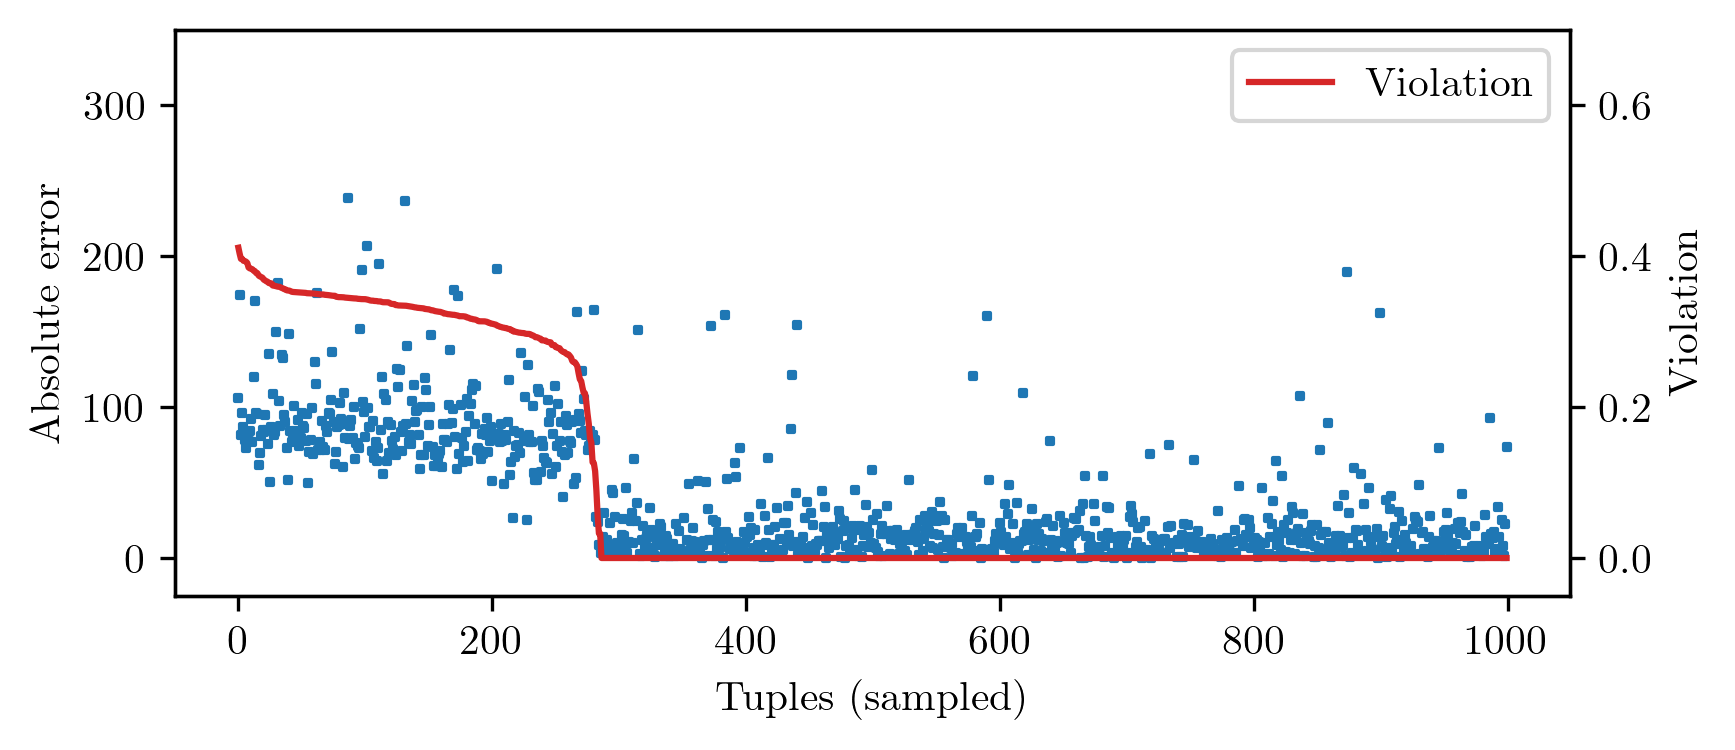

In [20]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import prose.datainsights as di
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import os
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

np.random.seed(0)
le = preprocessing.LabelEncoder()

columns = ["Year","Month","Day","DayOfWeek","CRSDepartureTime","CRSArrivalTime","UniqueCarrier","FlightNumber","ActualElapsedTime","Origin","Destination","Distance","Diverted","ArrivalDelay"]
df = pd.read_csv(os.path.join("data", "uncompressed", "2008_14col.data"), header=None, names=columns)
df = df[["Month","Day","CRSDepartureTime","CRSArrivalTime","UniqueCarrier","FlightNumber","ActualElapsedTime","Origin","Destination","Distance","Diverted","ArrivalDelay"]]
for col in ["UniqueCarrier",  "FlightNumber", "Origin", "Destination"]:    
    df[col] = le.fit_transform(df[col])
    
sameDay = df[df.CRSArrivalTime > df.CRSDepartureTime]  # This happens when the arrival is on same day
diffDay = df[df.CRSArrivalTime <= df.CRSDepartureTime] # This happens when the arrival is on next day

y = np.array(sameDay.ArrivalDelay)
x = np.array(sameDay.drop(columns=["ArrivalDelay"]))
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.95, test_size=0.05, random_state=0)

y_test_drifted = np.array(diffDay.ArrivalDelay)
x_test_drifted = np.array(diffDay.drop(columns=["ArrivalDelay"]))
x_test_all = np.vstack((x_test, x_test_drifted))
y_test_all = np.hstack((y_test, y_test_drifted))

x_train_df = pd.DataFrame(x_train, columns = [  "Month", "Day", "CRSDepartureTime", "CRSArrivalTime", "UniqueCarrier", "FlightNumber", "ActualElapsedTime", "Origin", "Destination", "Distance", "Diverted"])
x_test_df = pd.DataFrame(x_test, columns = [  "Month", "Day", "CRSDepartureTime", "CRSArrivalTime", "UniqueCarrier", "FlightNumber", "ActualElapsedTime", "Origin", "Destination", "Distance", "Diverted"])
x_test_drifted_df = pd.DataFrame(x_test_drifted, columns = [  "Month", "Day", "CRSDepartureTime", "CRSArrivalTime", "UniqueCarrier", "FlightNumber", "ActualElapsedTime", "Origin", "Destination", "Distance", "Diverted"])
x_test_all_df = pd.DataFrame(x_test_all, columns = [  "Month", "Day", "CRSDepartureTime", "CRSArrivalTime", "UniqueCarrier", "FlightNumber", "ActualElapsedTime", "Origin", "Destination", "Distance", "Diverted"])

assertions = di.learn_assertions(x_train_df, max_self_violation=1)
reg = LinearRegression().fit(x_train, y_train)


rcParams['font.family'] = 'serif'
rc('text', usetex=True)
rcParams['figure.dpi'] = 300

result = assertions.evaluate(x_test_df, explanation=True)
temp = result.row_wise_violation_summary
temp =  temp.sort_values(by=['violation'],  ascending=False)

pred_y = reg.predict(x_test)

temp["predicted_y"] = pred_y[np.array([int(k) for k in temp.index])]
temp["true_y"] = y_test[np.array([int(k) for k in temp.index])]
temp["MAE"] = np.abs(temp["true_y"] - temp["predicted_y"])

temp = temp[["violation", "predicted_y", "true_y", "MAE"]]

sampled_indexes = np.random.choice(range(x_test_all_df.shape[0]), 1000)
_x_test_all_df = x_test_all_df.iloc[sampled_indexes]

_x_test_all_df = _x_test_all_df.reset_index(drop=True)
_x_test_all =  x_test_all[sampled_indexes,:]
_y_test_all =  y_test_all[sampled_indexes]

result = assertions.evaluate(_x_test_all_df)

temp = result.row_wise_violation_summary
temp =  temp.sort_values(by=['violation'],  ascending=False)

pred_y = reg.predict(_x_test_all)

temp["predicted_y"] = pred_y[np.array([int(k) for k in temp.index])]
temp["true_y"] = _y_test_all[np.array([int(k) for k in temp.index])]
temp["MAE"] = np.abs(temp["true_y"] - temp["predicted_y"])

temp = temp[["violation", "predicted_y", "true_y", "MAE"]]

fig = plt.gcf()
fig.set_size_inches(6, 2.5)

plt.scatter(np.arange(temp.shape[0]), temp["MAE"], color="C0", marker="s", s=2, label="Absolute error")
plt.ylim([-25, 350])
plt.ylabel("Absolute error")
plt.xlabel("Tuples (sampled)")

tx = plt.twinx()
tx.plot(np.arange(temp.shape[0]), temp["violation"], color="C3", label="Violation")
tx.set_ylim([-0.05, 0.7])
tx.set_ylabel("Violation")
tx.legend()

plt.legend()
plt.savefig(os.path.join("Plots", "Figure_5.pdf"), bbox_inches="tight")
plt.show()